## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
from workspace_utils import active_session
import numpy as np # linear algebra
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
import pydicom
import seaborn as sns
from itertools import chain
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, f1_score
from skimage import io

from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


In [2]:
# Only for working from my local machine
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

tf.test.is_built_with_cuda()

Default GPU Device: /device:GPU:0


True

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
try:
    all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
    all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
except OSError as e:
    all_xray_df = pd.read_csv('/Healthcare/NIH Chest X-Rays/Data_Entry_2017.csv')
    all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/Healthcare/NIH Chest X-Rays','images*', '*', '*.png'))}
    

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
72809,00017946_000.png,Fibrosis,0,17946,77,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_008/images/00017946_000.png
104112,00027797_000.png,Cardiomegaly,0,27797,54,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_011/images/00027797_000.png
104444,00027927_036.png,Atelectasis,36,27927,59,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_011/images/00027927_036.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

# Enumeration of found labels
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')))))
print('Labels found: ({}) -> {}'.format(len(all_labels), all_labels))

# Rolling labels into columns in the dataset
for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
        

all_xray_df.sample(3)


Labels found: (15) -> ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
17419,00004680_003.png,No Finding,3,4680,30,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71443,00017607_000.png,Consolidation|Effusion,0,17607,47,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79714,00019576_060.png,No Finding,60,19576,49,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

all_xray_df['Pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda cls: "With" if cls==1 else "Without")

all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
27809,00007239_003.png,No Finding,3,7239,52,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without
94721,00024456_000.png,No Finding,0,24456,31,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without
89433,00022197_012.png,No Finding,12,22197,27,F,PA,2206,2353,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without


## Create your training and testing data:

In [6]:
def create_splits(stratification_class: str, split_ratio=0.2):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(all_xray_df,
                                               test_size=split_ratio,
                                               stratify=all_xray_df[stratification_class])
    return train_data, val_data

# Now we can begin our model-building & training

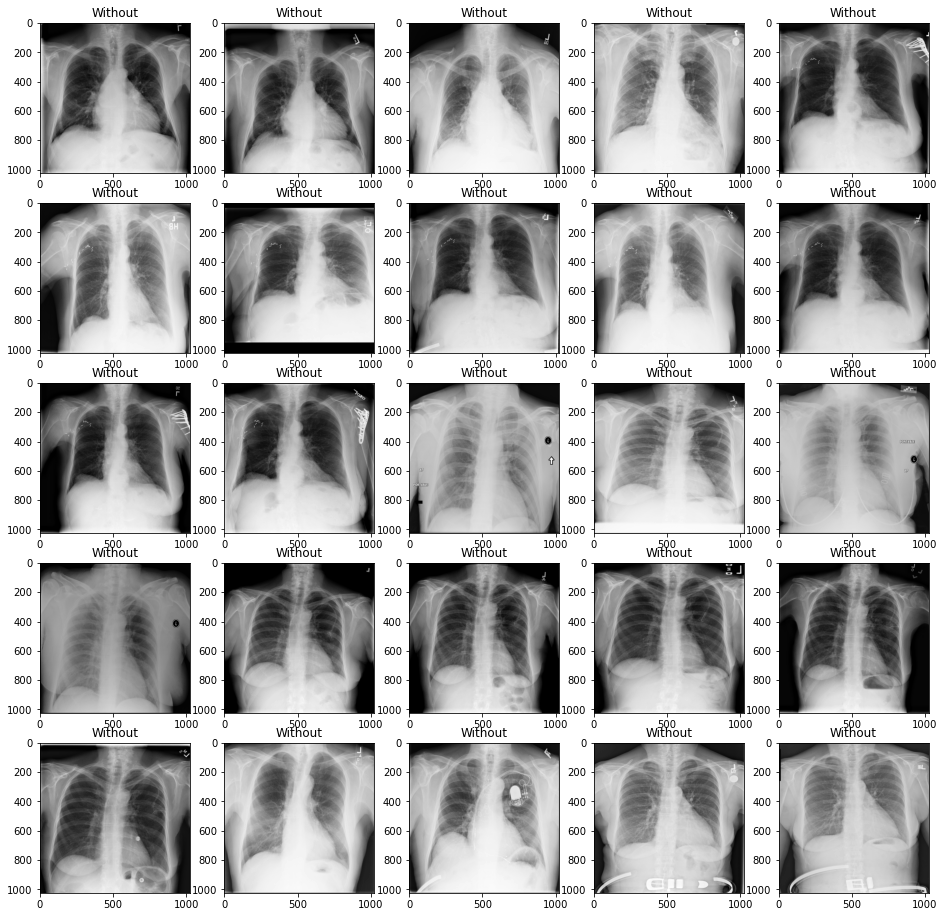

In [7]:
fig, m_axis = plt.subplots(5, 5, figsize= (16, 16))
m_axis = m_axis.flatten()
imgs = all_xray_df.path
ind=0

for img, ax in zip(imgs, m_axis):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[ind]['Pneumonia_class'])
    ind=ind+1
    

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    my_idg = ImageDataGenerator(
                            rescale=1./255.0,
                            horizontal_flip=True,
                            vertical_flip=False,
                            rotation_range=35,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.08,
                            fill_mode='nearest'
                            )
    
    return my_idg


def make_train_gen(y_col, img_size=(224,224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    train_gen = my_image_augmentation().flow_from_dataframe(
                                                    dataframe=train_data,
                                                    directory=None,
                                                    x_col='path',
                                                    y_col=y_col,
                                                    class_mode ='binary',
                                                    target_size=img_size,
                                                    batch_size=16,
                                                    shuffle=True,
                                                    validate_filenames=True
                                                    )
    
    return train_gen


def make_val_gen(y_col, img_size=(224,224)):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    
    val_gen = my_image_augmentation().flow_from_dataframe(
                                                dataframe=val_data,
                                                directory=None,
                                                x_col='path',
                                                y_col=y_col,
                                                class_mode ='binary',
                                                target_size=img_size,
                                                batch_size=8,
                                                shuffle=True,
                                                validate_filenames=True
                                                )
        
    return val_gen

In [9]:
train_data, val_data = create_splits('Pneumonia', 0.2)

train_gen = make_train_gen('Pneumonia_class')
val_gen = make_val_gen('Pneumonia_class')

type(train_gen)

print(len(val_gen))

Found 89696 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.
2803


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

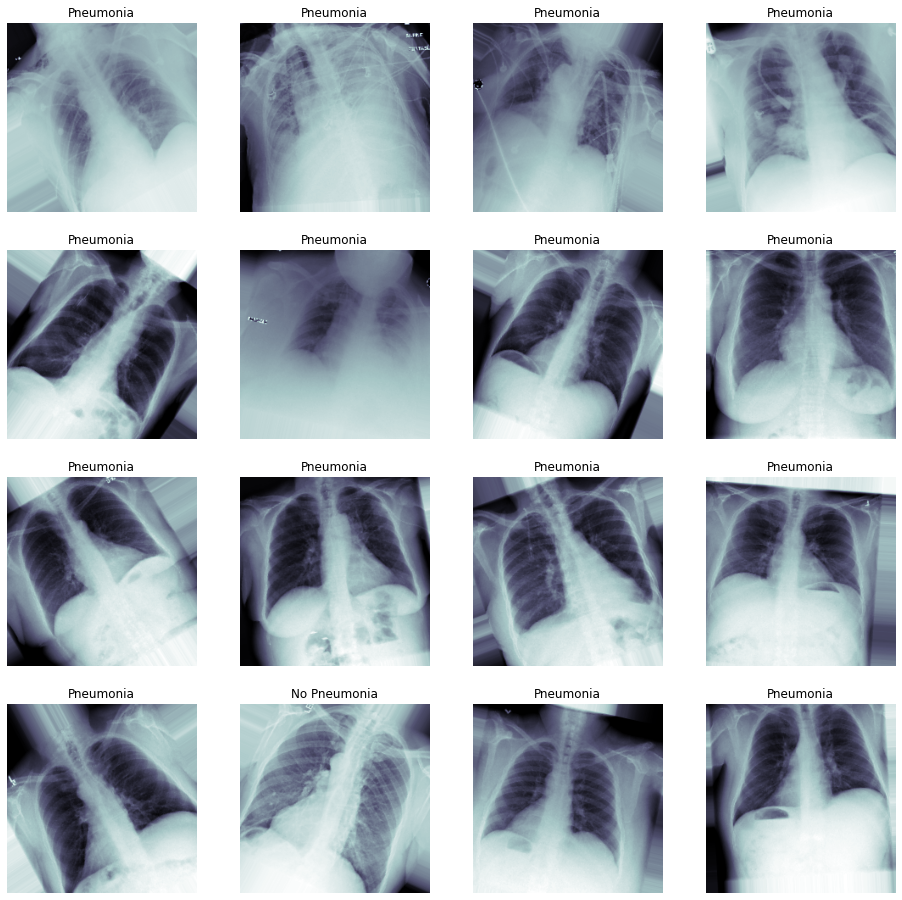

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model(pre_weights = 'imagenet'):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    vgg_model = VGG16(include_top=True, weights=pre_weights)
    

    
    return vgg_model


In [13]:
vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [14]:
def build_my_model(pre_trained_model, no_lyrs_to_frz, learning_rate = 1e-4):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    transfer_layer = pre_trained_model.get_layer('block5_pool')
    pre_trained_model = Model(inputs=pre_trained_model.input, 
                              outputs=transfer_layer.output)

    
    for layer in pre_trained_model.layers[0:no_lyrs_to_frz]:
        layer.trainable = False
    
    
    my_model = Sequential()
    
    my_model.add(pre_trained_model)
    
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.5))

    my_model.add(Dense(1024, activation='relu'))
    
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(256, activation='relu'))
    
    my_model.add(Dense(1, activation='sigmoid'))
    
    
    #optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    optimizer = Adam(lr=learning_rate)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
my_model = build_my_model(vgg_model, 17)

my_model.summary()

plot_model(vgg_model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [16]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_binary_accuracy', 
                      mode= 'max', 
                      patience=2)

callbacks_list = [checkpoint, early]

### Start training! 

In [17]:
## train your model

# Todo
with active_session():
    
    history = my_model.fit_generator(train_gen, 
                              validation_data = (valX, valY), 
                              epochs = 2, 
                              callbacks = callbacks_list)
    
    history_dic = history.history

Epoch 1/2
5606/5606 [==============================] - 2524s 450ms/step - loss: 0.0817 - binary_accuracy: 0.9871 - val_loss: 0.0045 - val_binary_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00447, saving model to xray_class_my_model.best.hdf5
Epoch 2/2
5606/5606 [==============================] - 2331s 416ms/step - loss: 0.0803 - binary_accuracy: 0.9872 - val_loss: 0.0430 - val_binary_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00447


In [30]:
# Saving model training history
#print(history.history['loss'])
import json

history_dic = history.history

print(history)
type(history)
print(history.params)
type(history.params)
print(history.history)
type(history.history)

json.dump(str(history_dic), open('my_model_history_dic', 'w'))

NameError: name 'history' is not defined

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [31]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

8/8 [==============================] - 10s 1s/step


In [32]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fpr, tpr, thresh = roc_curve(t_y, p_y, pos_label=1)
    
    return fpr, tpr, thresh

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo
def auc_score_metrics(t_y, p_y):

    fpr, tpr, thresh = roc_curve(t_y, p_y, pos_label=1)
    
    auc_score = roc_auc_score(t_y, p_y)
    
    return auc_score, fpr, tpr, thresh
# def ...
# Todo

#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    return


In [33]:
## plot figures

plot_history(history)
my_model.history
# Todo

NameError: name 'history' is not defined

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [40]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

# Since the dataset exhibits an imbalanced problem, the Accuracy metric wouldn't be best to use
# F1 Score
print(valY)
print(pred_Y>0.7)
print('F1 is: ', f1_score(valY, pred_Y>0.5))



[1. 1. 1. 1. 1. 1. 1. 1.]
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]]
F1 is:  1.0


In [23]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [24]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)